In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from pathlib import Path
from collections import Counter
from sklearn.cluster import DBSCAN
import numpy as np


In [2]:
df = pd.read_pickle("data/flickr_data_cleaned.pkl")
df.head(5)

,id,user,lat,long,tags,title,date_upload,date_taken
0,4395181099,30624617@N03,45.754858,4.821710,"[chair, lyon, rhône, chaise, rhônealpes]",Chaises avec vue,2010-02-28 20:23:00,2010-02-28 15:11:00
1,4394748717,35853470@N00,45.753270,4.862953,[],,2010-02-28 17:52:00,2010-02-28 17:51:00
2,4394694699,11817998@N05,45.760655,4.846564,"[365, iphone]",59/365 - R46 V103 B163,2010-02-28 17:33:00,2010-02-28 17:29:00
3,4394803790,11545749@N06,45.784000,4.874072,"[nin, nineinchnails, gift, screening, toiou, a...",2010-01-29 Toiou Avott Lyon,2010-02-28 12:38:00,2010-01-28 20:15:00
4,4394803554,11545749@N06,45.784000,4.874072,"[lyon, nin, nineinchnails, gift, screening, to...",2010-01-28 Toiou Avott Lyon,2010-02-28 12:38:00,2010-01-28 20:10:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185209 entries, 0 to 420239
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           185209 non-null  int64         
 1   user         185209 non-null  object        
 2   lat          185209 non-null  float64       
 3   long         185209 non-null  float64       
 4   tags         185209 non-null  object        
 5   title        185209 non-null  object        
 6   date_upload  185209 non-null  datetime64[ns]
 7   date_taken   185209 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 12.7+ MB


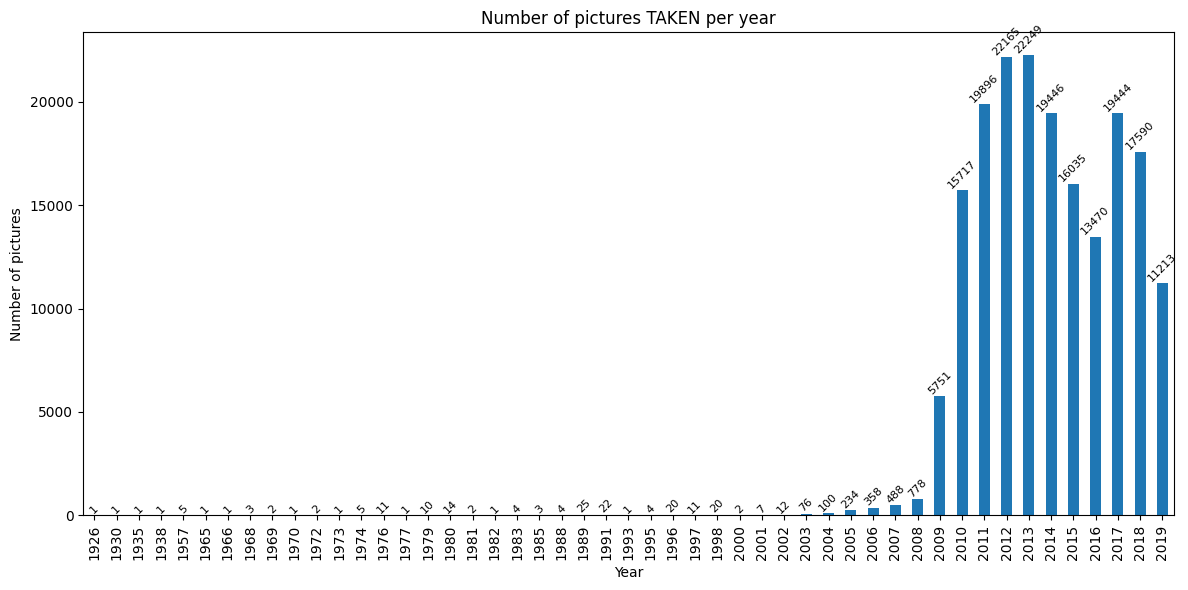

In [4]:
ax = df["date_taken"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures TAKEN per year")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

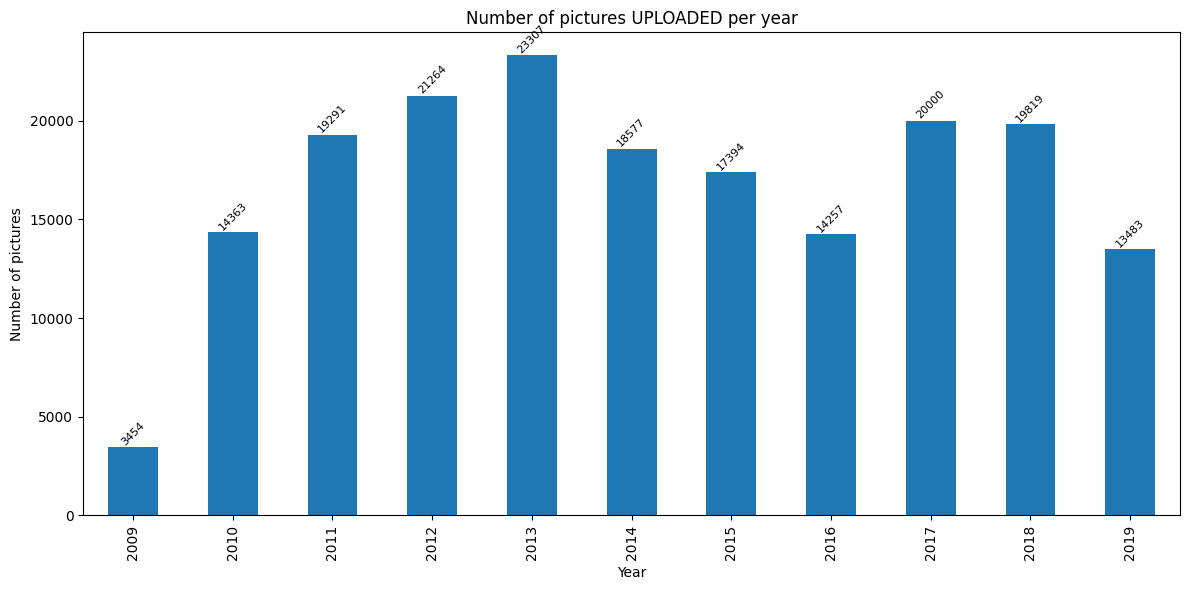

In [5]:
ax = df["date_upload"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures UPLOADED per year")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

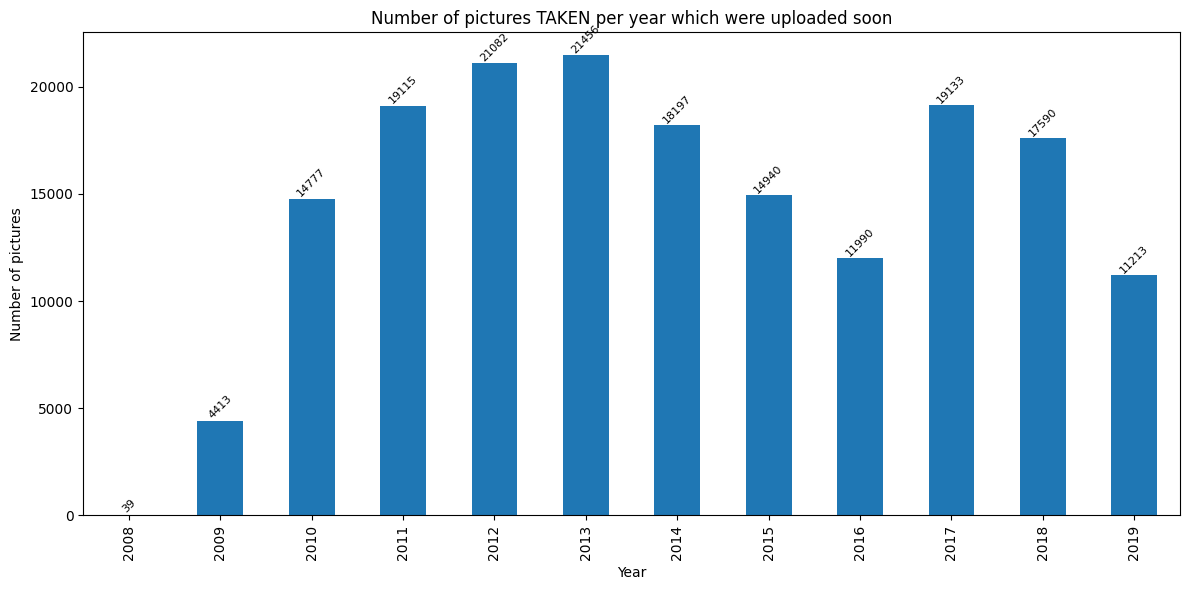

In [6]:
# distribution of pictures with the small difference between date_taken and date_upload
similar_mask = df["date_upload"].dt.year - df["date_taken"].dt.year <= 1
similar_year = df[similar_mask]
ax = similar_year["date_taken"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures TAKEN per year which were uploaded soon")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

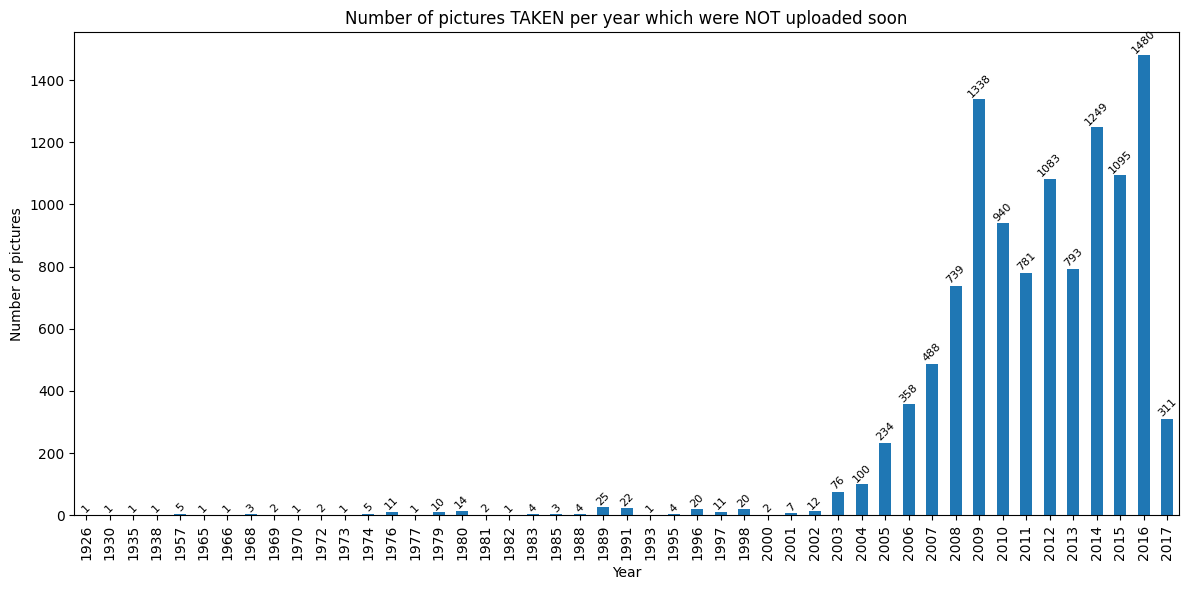

In [7]:
diff_year = df[~similar_mask]
ax = diff_year["date_taken"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures TAKEN per year which were NOT uploaded soon")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

In [8]:
df['similar_year'] = similar_mask

Total unique tags: 44568
Total tags: 2073924



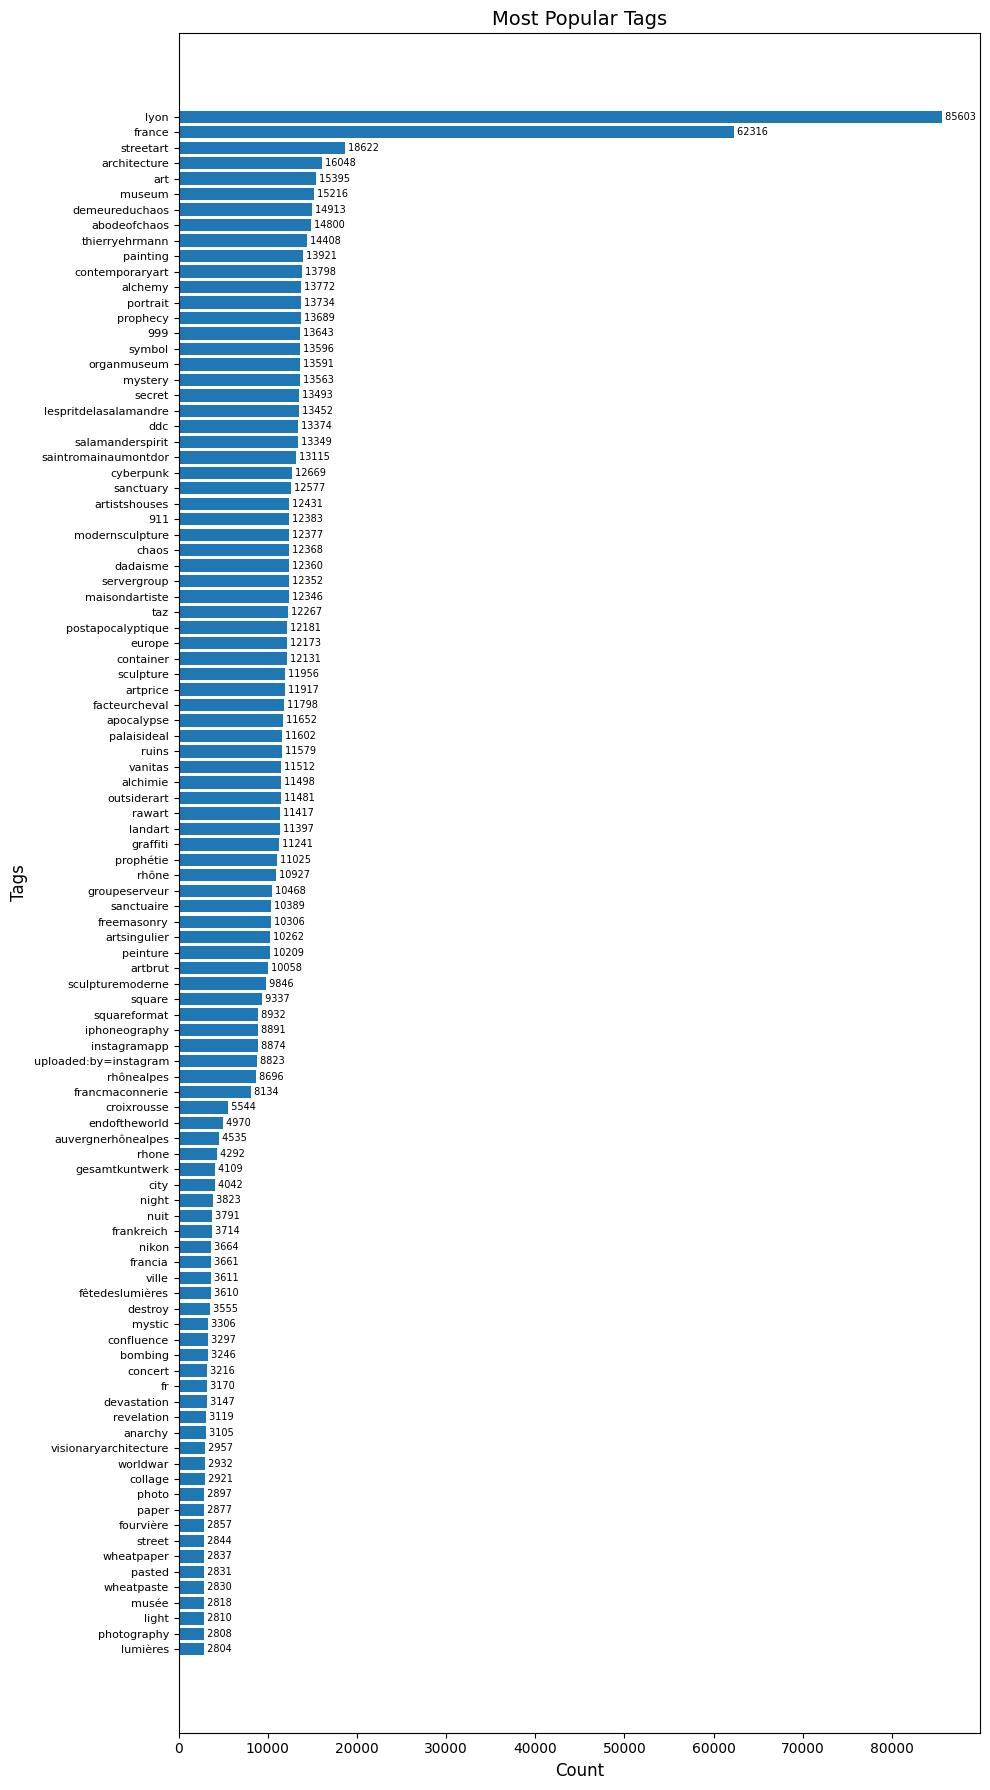

In [9]:
all_tags = []
for tags_list in df["tags"]:
    if tags_list and isinstance(tags_list, list):
        all_tags.extend(tags_list)

tag_counts = Counter(all_tags)
print(f"Total unique tags: {len(tag_counts)}")
print(f"Total tags: {len(all_tags)}\n")

top_tags = tag_counts.most_common(100)
tags, counts = zip(*top_tags)

fig, ax = plt.subplots(figsize=(10, 18))
ax.barh(range(len(tags)), counts)
ax.set_yticks(range(len(tags)))
ax.set_yticklabels(tags, fontsize=8)
ax.set_xlabel("Count", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Most Popular Tags", fontsize=14)
ax.invert_yaxis()  # Most popular at the top

for i, count in enumerate(counts):
    ax.text(count, i, f" {count}", va='center', fontsize=7)

plt.tight_layout()
plt.show()

In [10]:
YEAR = 2016

sample = df[df["date_taken"].dt.year == YEAR].copy()
coords = sample[["lat", "long"]].values

EARTH_RADIUS = 6371.0  # in km

clustering = DBSCAN(eps=0.07 / EARTH_RADIUS, min_samples=60, metric="haversine").fit(np.radians(coords))
sample["cluster"] = clustering.labels_

n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
n_noise = list(clustering.labels_).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"\nCluster distribution:")
print(sample["cluster"].value_counts().sort_index())

Number of clusters: 36
Number of noise points: 5147

Cluster distribution:
cluster
-1     5147
 0       72
 1      204
 2      577
 3     1356
 4      515
 5       68
 6      289
 7      595
 8      322
 9      486
 10     274
 11     158
 12     212
 13     198
 14     133
 15     128
 16      69
 17     158
 18     111
 19      94
 20     163
 21      74
 22      81
 23      72
 24     352
 25     138
 26      93
 27     345
 28      41
 29      82
 30     108
 31      98
 32     232
 33      85
 34      68
 35     272
Name: count, dtype: int64


In [11]:
save_dir = Path("./data/explore/")
save_dir.mkdir(parents=True, exist_ok=True)

m = folium.Map(location=[45.75, 4.85], zoom_start=12)  # Centered on Lyon, France

colors = ["red", "blue", "green", "purple", "orange", "darkred", "lightred", "beige", "darkblue", "darkgreen"]

for _, row in sample.iterrows():
    cluster_id = row["cluster"]

    # Noise points get gray color
    if cluster_id == -1:
        color = "gray"
    else:
        # Cycle through colors based on cluster ID
        color = colors[cluster_id % len(colors)]

    if row["similar_year"] == 1:
        # Circle for similar years
        folium.CircleMarker(
            location=[row["lat"], row["long"]],
            radius=6,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.5,
            popup=f"Cluster: {cluster_id} | Similar Year: True",
        ).add_to(m)
    else:
        # Square for non-similar years
        folium.RegularPolygonMarker(
            location=[row["lat"], row["long"]],
            fill_color=color,
            number_of_sides=4,
            radius=6,
            color=color,
            fill_opacity=0.5,
            popup=f"Cluster: {cluster_id} | Similar Year: False",
        ).add_to(m)

m.save(str(save_dir / f"{YEAR}_clusters_map.html"))
print("Cluster map saved!")

Cluster map saved!
